# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [22]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv(url, parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])

In [24]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [26]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [27]:
df = df.fillna('unknown')

In [28]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [29]:
df[(df.Price==0)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,2016-03-26,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,unknown,0,unknown,5000,0,petrol,volkswagen,unknown,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,unknown,2000,manual,65,corsa,150000,0,unknown,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


In [30]:
df[(df.RegistrationYear<1900) | (df.RegistrationYear>2022)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,unknown,1111,unknown,0,unknown,5000,0,unknown,opel,unknown,2016-03-16,0,44628,2016-03-20 16:44:37
12946,2016-03-29 18:39:40,49,unknown,5000,unknown,0,golf,5000,12,unknown,volkswagen,unknown,2016-03-29,0,74523,2016-04-06 04:16:14
15147,2016-03-14 00:52:02,0,unknown,9999,unknown,0,unknown,10000,0,unknown,sonstige_autos,unknown,2016-03-13,0,32689,2016-03-21 23:46:46
15870,2016-04-02 11:55:48,1700,unknown,3200,unknown,0,unknown,5000,0,unknown,sonstige_autos,unknown,2016-04-02,0,33649,2016-04-06 09:46:13
16062,2016-03-29 23:42:16,190,unknown,1000,unknown,0,mondeo,5000,0,unknown,ford,unknown,2016-03-29,0,47166,2016-04-06 10:44:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340548,2016-04-02 17:44:03,0,unknown,3500,manual,75,unknown,5000,3,petrol,sonstige_autos,unknown,2016-04-02,0,96465,2016-04-04 15:17:51
340759,2016-04-04 23:55:47,700,unknown,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:07
341791,2016-03-28 17:37:30,1,unknown,3000,unknown,0,zafira,5000,0,unknown,opel,unknown,2016-03-28,0,26624,2016-04-02 22:17:49
348830,2016-03-22 00:38:15,1,unknown,1000,unknown,1000,unknown,150000,0,unknown,sonstige_autos,unknown,2016-03-21,0,41472,2016-04-05 14:18:01


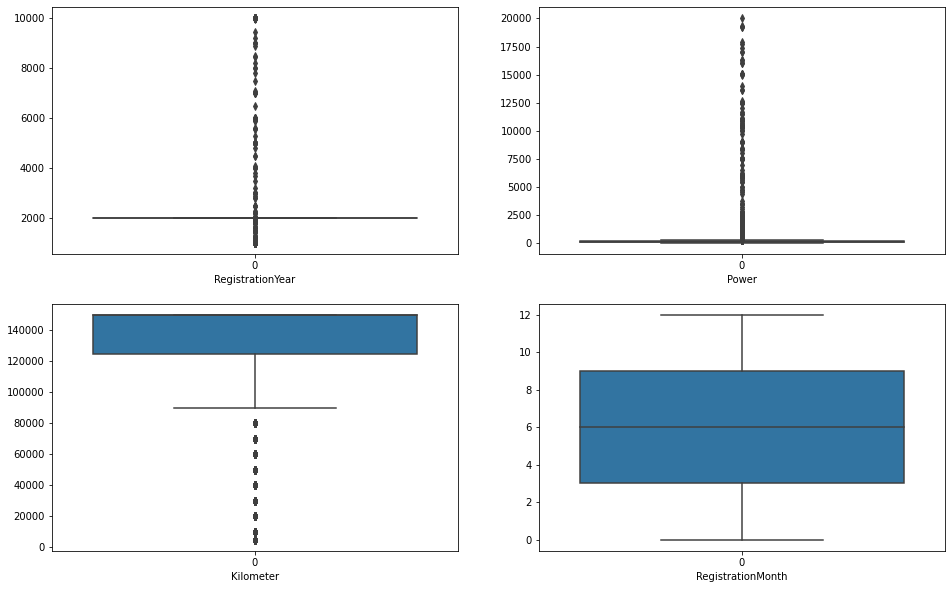

In [31]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(16,10))
sns.boxplot(data=df.RegistrationYear, ax=ax1[0])
sns.boxplot(data=df.Power, ax=ax1[1])
sns.boxplot(data=df.Kilometer, ax=ax2[0])
sns.boxplot(data=df.RegistrationMonth, ax=ax2[1])
ax1[0].set_xlabel("RegistrationYear")
ax1[1].set_xlabel("Power");
ax2[0].set_xlabel("Kilometer")
ax2[1].set_xlabel("RegistrationMonth");

Машина не может стоить 0 и ее год регистрации не может быть равен 1000, отфильтрую значение цены больше 0, а год больше 1985 и меньше 2022 и power больше 0 и меньше 250.

In [32]:
df = df[df.Price>0]
df = df[(df.RegistrationYear>1985) & (df.RegistrationYear<2022)]
df = df[(df.Power<250) & (df.Power>0)]
df = df[df.RegistrationMonth>0]

In [33]:
df = df.drop(['NumberOfPictures','DateCrawled','DateCreated','LastSeen'], axis=1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275960 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              275960 non-null  int64 
 1   VehicleType        275960 non-null  object
 2   RegistrationYear   275960 non-null  int64 
 3   Gearbox            275960 non-null  object
 4   Power              275960 non-null  int64 
 5   Model              275960 non-null  object
 6   Kilometer          275960 non-null  int64 
 7   RegistrationMonth  275960 non-null  int64 
 8   FuelType           275960 non-null  object
 9   Brand              275960 non-null  object
 10  NotRepaired        275960 non-null  object
 11  PostalCode         275960 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.4+ MB


### Вывод
- Заменил пропуски на 'unknown'.
- Удалил столбец `NumberOfPictures` так как в нем одни нули и столбцы и `DateCrawled`,`DateCreated`,`LastSeen`.
- В info увидел наличие null в данных
- В describe видно что в `Price`, `RegistrationYear`, `Power` и `RegistrationMonth` есть неправдоподобные значения.

## Обучение моделей

In [35]:
numeric_columns = ['Power', 'Kilometer', 'RegistrationYear', 'RegistrationMonth','PostalCode']

In [15]:
scaler = StandardScaler()
scaler.fit(df[numeric_columns])
df[numeric_columns] = scaler.transform(df[numeric_columns])

In [16]:
train, test = train_test_split(df, test_size=0.25, random_state=1234)

In [17]:
train_x = train.drop('Price', axis=1)
train_y = train['Price']
test_x = test.drop('Price', axis=1)
test_y = test['Price']

In [18]:
cat_features=[train_x.columns.get_loc(c) for c in train_x.dtypes[train_x.dtypes == 'object'].index]

In [19]:
cat_features

[0, 2, 4, 7, 8, 9]

In [20]:
encoder = LabelEncoder()
for col in cat_features:
    encoder.fit(train_x.iloc[:,col])
    train_x.iloc[:,col] = encoder.transform(train_x.iloc[:,col])
    test_x.iloc[:,col] = encoder.transform(test_x.iloc[:,col])

In [21]:
train_x

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
212790,7,2.031828,1,-0.588377,116,0.596474,-1.010909,6,38,0,-0.209203
6710,8,0.540627,1,0.519541,29,0.596474,-1.309500,2,1,0,0.041788
292025,6,-0.619196,0,1.937676,166,0.596474,0.780642,4,10,2,-0.787024
277608,4,0.374938,1,0.320116,154,0.596474,-1.010909,6,10,0,0.460704
205206,5,0.374938,1,0.320116,173,0.596474,1.079233,2,38,0,1.040896
...,...,...,...,...,...,...,...,...,...,...,...
178906,2,-1.613330,1,-0.632694,10,0.596474,0.780642,6,19,2,-1.077198
12292,4,-0.122129,1,1.184292,11,0.596474,-1.010909,6,2,0,1.372196
53039,6,0.043560,1,-0.123052,108,0.596474,-0.712317,2,18,0,0.205553
283041,1,-0.122129,0,-0.100893,56,-0.768721,-0.115134,6,5,0,-0.406358


### Catboost

In [21]:
cat_model = CatBoostRegressor()
# set up our search grid
param_grid = {"max_depth":    [10],
              "n_estimators": [200, 400],
              "verbose": [200],
              "learning_rate": [0.05, 0.1]}

# try out every combination of the above values
search = GridSearchCV(cat_model, param_grid, cv=4).fit(train_x, train_y)

print("The best hyperparameters are ",search.best_params_)

0:	learn: 4315.5191112	total: 102ms	remaining: 20.3s
199:	learn: 1546.0007504	total: 10.9s	remaining: 0us
0:	learn: 4315.7378641	total: 51ms	remaining: 10.1s
199:	learn: 1541.7382789	total: 14.2s	remaining: 0us
0:	learn: 4325.0780217	total: 48.7ms	remaining: 9.7s
199:	learn: 1547.1507307	total: 11s	remaining: 0us
0:	learn: 4320.6899164	total: 55.1ms	remaining: 11s
199:	learn: 1546.5904600	total: 10.1s	remaining: 0us
0:	learn: 4315.5191112	total: 52.2ms	remaining: 20.8s
200:	learn: 1545.2870522	total: 9.92s	remaining: 9.82s
399:	learn: 1443.2600455	total: 19.8s	remaining: 0us
0:	learn: 4315.7378641	total: 49.7ms	remaining: 19.8s
200:	learn: 1541.1858785	total: 9.94s	remaining: 9.84s
399:	learn: 1439.0507394	total: 19.9s	remaining: 0us
0:	learn: 4325.0780217	total: 48.6ms	remaining: 19.4s
200:	learn: 1546.5700597	total: 10.3s	remaining: 10.2s
399:	learn: 1444.6735593	total: 20.4s	remaining: 0us
0:	learn: 4320.6899164	total: 50ms	remaining: 19.9s
200:	learn: 1545.8295253	total: 9.98s	rema

In [22]:
cat_model = CatBoostRegressor(learning_rate = search.best_params_["learning_rate"],
                              n_estimators  = search.best_params_["n_estimators"],
                              max_depth     = search.best_params_["max_depth"],
                              verbose       = search.best_params_["verbose"])

In [23]:
%%time
start_time = time.time()
cat_model.fit(train_x,
              train_y,
#               cat_features=cat_features,
              eval_set=(test_x, test_y),
              plot=True)
fit_time_catboost = time.time() - start_time
prediction_catboost = cat_model.predict(test_x)
predicting_time_catboost = time.time() - start_time
predicting_time_catboost -= fit_time_catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4156.2312093	test: 4171.7662367	best: 4171.7662367 (0)	total: 71.9ms	remaining: 28.7s
200:	learn: 1452.4697196	test: 1532.3342376	best: 1532.3342376 (200)	total: 13.1s	remaining: 12.9s
399:	learn: 1353.9641275	test: 1483.2018959	best: 1483.2018959 (399)	total: 25.9s	remaining: 0us

bestTest = 1483.201896
bestIteration = 399

CPU times: user 26.1 s, sys: 116 ms, total: 26.2 s
Wall time: 27.7 s


In [24]:
fit_time_catboost, predicting_time_catboost, cat_model.best_score_['validation']['RMSE'], mean_squared_error(prediction_catboost, test_y, squared=0)

(27.64411473274231,
 0.10434174537658691,
 1483.2018959423851,
 1483.2018959423845)

### LGBMRegressor

In [25]:
lgbm_model = LGBMRegressor()
# set up our search grid
param_grid = {"max_depth":    [10],
              "n_estimators": [200, 400],
              "learning_rate": [0.05, 0.1]}

# try out every combination of the above values
search = GridSearchCV(lgbm_model, param_grid, cv=4).fit(train_x, train_y)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}


In [26]:
lgbm_model = LGBMRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])

In [27]:
%%time
start_time = time.time()
lgbm_model.fit(train_x,
               train_y,
               eval_set = (test_x, test_y),
               eval_metric ='rmse',
               callbacks=[early_stopping(100), log_evaluation(200)])
fit_time_lgbm = time.time() - start_time
prediction_lgbm = lgbm_model.predict(test_x)
predicting_time_lgbm = time.time() - start_time
predicting_time_lgbm -= fit_time_lgbm

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1547.69	valid_0's l2: 2.39536e+06
[400]	valid_0's rmse: 1502.67	valid_0's l2: 2.25802e+06
Did not meet early stopping. Best iteration is:
[400]	valid_0's rmse: 1502.67	valid_0's l2: 2.25802e+06
CPU times: user 18.5 s, sys: 79.7 ms, total: 18.6 s
Wall time: 19 s


In [28]:
fit_time_lgbm, predicting_time_lgbm, lgbm_model.best_score_['valid_0']['rmse'], mean_squared_error(prediction_lgbm, test_y, squared=0)

(17.18799114227295, 1.8056261539459229, 1502.6718368043148, 1502.6718368043148)

### XGBRegressor

In [29]:
xgb_model = xgb.XGBRegressor(eval_metric ='rmse')
# set up our search grid
param_grid = {"max_depth":    [10],
              "n_estimators": [200, 400],
              "learning_rate": [0.05, 0.1]}

# try out every combination of the above values
search = GridSearchCV(xgb_model, param_grid, cv=4).fit(train_x, train_y)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}


In [30]:
xgb_model = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                             n_estimators  = search.best_params_["n_estimators"],
                             max_depth     = search.best_params_["max_depth"])

In [31]:
%%time
start_time = time.time()
xgb_model.fit(train_x,
              train_y,
              eval_set = [(test_x, test_y)],
              eval_metric ='rmse',
              verbose=0)
fit_time_xgb = time.time() - start_time
prediction_xgb = xgb_model.predict(test_x)
predicting_time_xgb = time.time() - start_time
predicting_time_xgb -= fit_time_xgb

CPU times: user 10min 24s, sys: 2.55 s, total: 10min 27s
Wall time: 10min 32s


In [32]:
fit_time_xgb, predicting_time_xgb, mean_squared_error(prediction_xgb, test_y, squared=0)

(630.1551172733307, 2.2557263374328613, 1409.981112583814)

## Анализ моделей

In [33]:
pd.DataFrame({'fit_time':[fit_time_catboost, fit_time_lgbm, fit_time_xgb], 
              'predicting_time':[predicting_time_catboost, predicting_time_lgbm, predicting_time_xgb], 
              'rmse':[cat_model.best_score_['validation']['RMSE'], 
                      lgbm_model.best_score_['valid_0']['rmse'], 
                      mean_squared_error(prediction_xgb, test_y, squared=0)]}, 
             index=['CatBoostRegressor','LGBMRegressor','XGBRegressor'])

,fit_time,predicting_time,rmse
CatBoostRegressor,27.644115,0.104342,1483.201896
LGBMRegressor,17.187991,1.805626,1502.671837
XGBRegressor,630.155117,2.255726,1409.981113


### Вывод 
- Лучшее качество предсказания у XGBRegressor, но время обучения самое долгое. 
- Оптимальнее всего использовать CatBoostRegressor у него лучшее время предсказаний, недолгое обучение и среднее качество предсказаний.